In [36]:
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
# packages to predict anomalies 
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
%matplotlib inline
plt.style.use('fivethirtyeight')

In [29]:
cryptocompare = pd.read_csv('cryptocompare_anomalies_table.csv',index_col=0)
coinmarketcap = pd.read_csv('coinmarketcap_anomalies_table.csv',index_col=0)
coinbase = pd.read_csv('coinbase_anomalies_table.csv',index_col=0)
bitstamp = pd.read_csv('bitstamp_anomalies_table.csv',index_col=0)
kraken = pd.read_csv('kraken_anomalies_table.csv',index_col=0)

cryptocompare_prices = pd.read_csv('cc_trends_data.csv',index_col=0)
coinmarketcap_prices = pd.read_csv('cmc_trends_data.csv',index_col=0)
kraken_prices = pd.read_csv('kraken_trends_data.csv',index_col=0)
bitstamp_prices = pd.read_csv('bitstamp_trends_data.csv',index_col=0)
coinbase_prices = pd.read_csv('coinbase_trends_data.csv',index_col=0)

social = pd.read_csv('social_anomalies_table.csv',index_col=0)
blockchain = pd.read_csv('blockchain_anomalies_table.csv',index_col=0)
blockchain_data = pd.read_csv('blockchain_for_modeling.csv',index_col=0)
social_data = pd.read_csv('social_for_modeling.csv',index_col=0)

In [3]:
# get variable name
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def ohlc_plot(df,Open,High,Low,Close,Volume,title):
    fig, ax1 = plt.subplots(figsize=(16, 6))

    width=1
    width2=0.1
    df.index = pd.to_datetime(df.index)
    pricesup=df[df[Close]>=df[Open]]
    pricesdown=df[df[Close]<df[Open]]

    ax1.bar(pricesup.index,pricesup[Close]-pricesup[Open],width,bottom=pricesup[Open],color='g')
    ax1.bar(pricesup.index,pricesup[High]-pricesup[Close],width2,bottom=pricesup[Close],color='g')
    ax1.bar(pricesup.index,pricesup[Low]-pricesup[Open],width2,bottom=pricesup[Open],color='g')

    ax1.bar(pricesdown.index,pricesdown[Close]-pricesdown[Open],width,bottom=pricesdown[Open],color='r')
    ax1.bar(pricesdown.index,pricesdown[High]-pricesdown[Open],width2,bottom=pricesdown[Open],color='r')
    ax1.bar(pricesdown.index,pricesdown[Low]-pricesdown[Close],width2, bottom=pricesdown[Close],color='r')
    plt.grid()

    ax2 = ax1.twinx() 
    ax2.bar(x= df.index,height=df[Volume],alpha=0.4)
    plt.title('Bitcoin OHLC chart vs Volume for '+title, size=16)
    fig.tight_layout()
    plt.show()

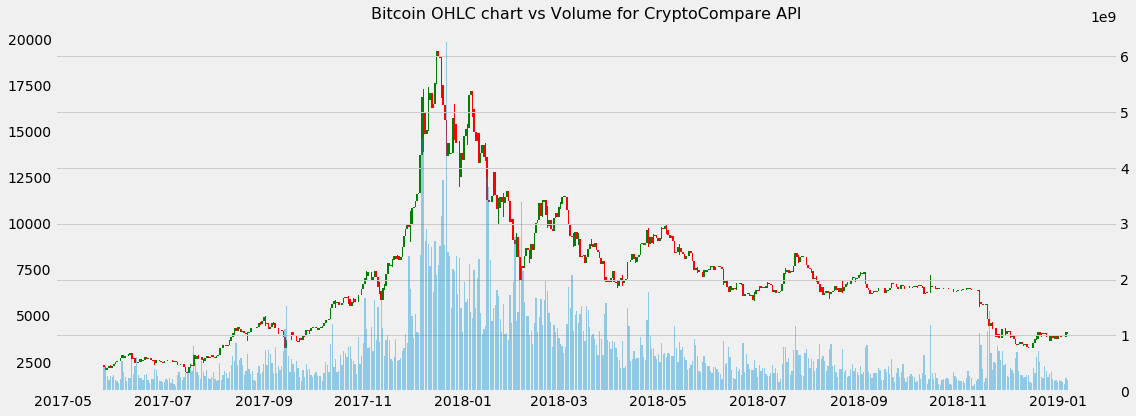

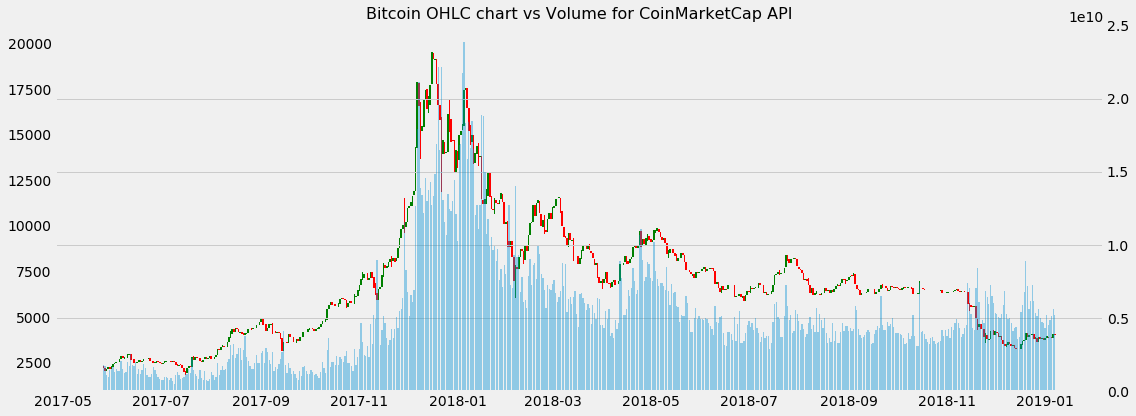

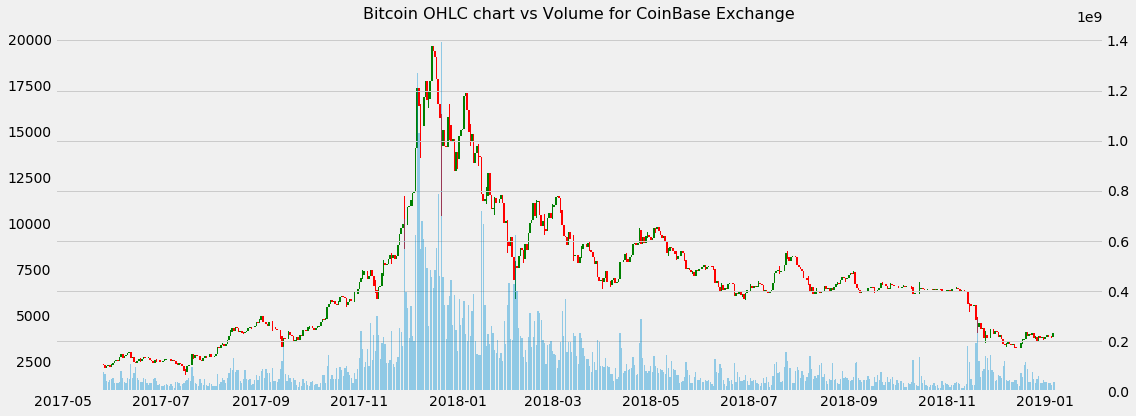

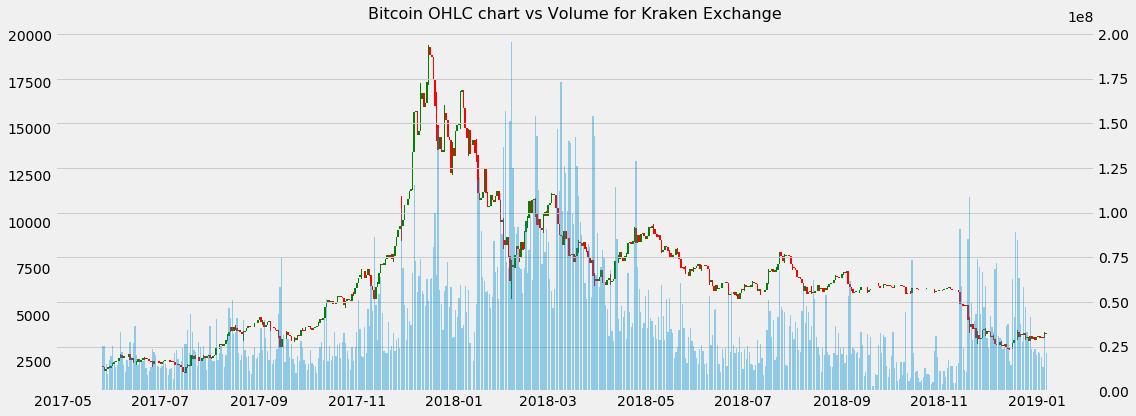

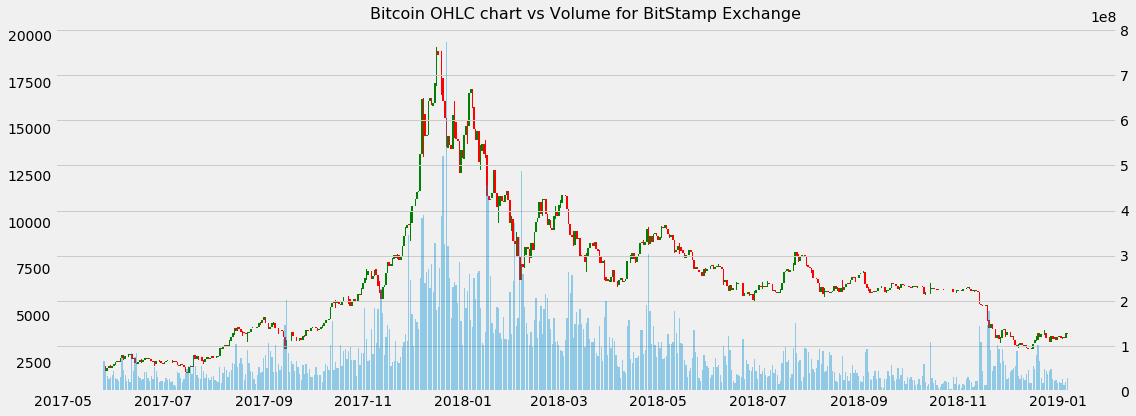

In [4]:
ohlc_plot(cryptocompare_prices,'open','high','low','close','volumeto','CryptoCompare API')
ohlc_plot(coinmarketcap_prices,'open','high','low','close','volume','CoinMarketCap API')
ohlc_plot(coinbase_prices,'Open','High','Low','Close','Volume (Currency)','CoinBase Exchange')
ohlc_plot(kraken_prices,'Open','High','Low','Close','Volume (Currency)','Kraken Exchange')
ohlc_plot(bitstamp_prices,'Open','High','Low','Close','Volume (Currency)','BitStamp Exchange')

Text(0.5, 1, 'Correlation Matrix between all Volumes across datasets')

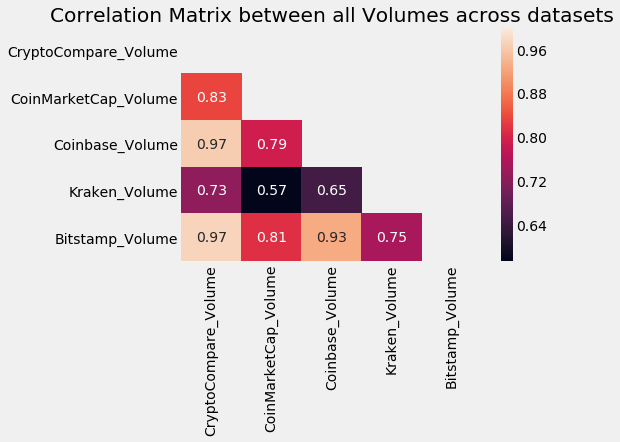

In [5]:
all_volumes = pd.concat([cryptocompare_prices['volumeto'],coinmarketcap_prices['volume'],coinbase_prices['Volume (Currency)'],kraken_prices['Volume (Currency)'],bitstamp_prices['Volume (Currency)']],axis=1)
all_volumes.columns = ['CryptoCompare_Volume','CoinMarketCap_Volume','Coinbase_Volume','Kraken_Volume','Bitstamp_Volume']
corr = all_volumes.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)
plt.title('Correlation Matrix between all Volumes across datasets')



In [ ]:
# plot all anomalies, plot unique anomalies, different anomalies + composition and difference
# small/big volume to close vs anomaly 
# what makes this dates an anomaly 

## Summary

In [4]:
# same anomalies across price datasets
same_price_anomalies = set(kraken.Date)&set(coinbase.Date)&set(cryptocompare.Date)&set(coinmarketcap.Date)&set(bitstamp.Date)
# using coinbase as the most reliable we examine which anomaly dates deviate from it
coinbase_cc_difference = set(coinbase.Date) - set(cryptocompare.Date)
coinbase_cmc_difference = set(coinbase.Date) - set(coinmarketcap.Date)
coinbase_bitstamp_difference = set(coinbase.Date) - set(bitstamp.Date)
coinbase_kraken_difference = set(coinbase.Date) - set(kraken.Date)
# what anomalies other datasets have that coinbase does not 
cc_coinbase_difference = set(cryptocompare.Date) - set(coinbase.Date) 
cmc_coinbase_difference = set(coinmarketcap.Date) - set(coinbase.Date) 
bitstamp_coinbase_difference = set(bitstamp.Date) - set(coinbase.Date) 
kraken_coinbase_difference = set(kraken.Date) - set(coinbase.Date)
# blockchain and social media difference to coinbase and eachother
coinbase_block_difference = set(coinbase.Date) - set(blockchain.Date)
block_coinbase_difference = set(blockchain.Date) - set(coinbase.Date)
coinbase_social_difference = set(coinbase.Date) - set(social.Date)
social_coinbase_difference = set(social.Date) - set(coinbase.Date)
block_social_difference = set(blockchain.Date) - set(social.Date)
social_block_difference = set(social.Date) - set(blockchain.Date)
# blockchain, social, and coinbase same anomalies
coinbase_social_blockSAME = set(coinbase.Date) & set(social.Date) & set(blockchain.Date)
social_coinbase_same = set(social.Date) & set(coinbase.Date)
block_social_same = set(blockchain.Date) & set(social.Date)
block_coinbase_same = set(coinbase.Date) & set(blockchain.Date)

print('CoinMarketCap number of unique date anomalies: ',len(coinmarketcap.Date.unique()))
print('Cryptocompare number of unique date anomalies: ',len(cryptocompare.Date.unique()))
print('Coinbase number of unique date anomalies: ',len(coinbase.Date.unique()))
print('Bitstamp number of unique date anomalies: ',len(bitstamp.Date.unique()))
print('Kraken number of unique date anomalies: ',len(kraken.Date.unique()),'\n')

print('Same anomalies between all price datasets: ', len(same_price_anomalies),'\n')

print('Coinbase different anomalies to cryptocompare: ',len(coinbase_cc_difference))
print('Coinbase different anomalies to coinmarketcap: ',len(coinbase_cmc_difference))
print('Coinbase different anomalies to bitstamp: ',len(coinbase_bitstamp_difference))
print('Coinbase different anomalies to kraken: ',len(coinbase_kraken_difference),'\n')

print('cryptocompare different anomalies to Coinbase: ',len(cc_coinbase_difference))
print('coinmarketcap different anomalies to Coinbase: ',len(cmc_coinbase_difference))
print('bitstamp different anomalies to Coinbase: ',len(bitstamp_coinbase_difference))
print('kraken different anomalies to Coinbase: ',len(kraken_coinbase_difference),'\n')

print('Blockchain number of unique date anomalies: ', len(blockchain.Date.unique()))
print('Social media number of unique date anomalies: ', len(social.Date.unique()))
print('Blockchain, social, & coinbase number of unique date anomalies: ',len(set(coinbase.Date) & set(social.Date) & set(blockchain.Date)))

CoinMarketCap number of unique date anomalies:  113
Cryptocompare number of unique date anomalies:  115
Coinbase number of unique date anomalies:  117
Bitstamp number of unique date anomalies:  123
Kraken number of unique date anomalies:  117 

Same anomalies between all price datasets:  81 

Coinbase different anomalies to cryptocompare:  17
Coinbase different anomalies to coinmarketcap:  19
Coinbase different anomalies to bitstamp:  11
Coinbase different anomalies to kraken:  20 

cryptocompare different anomalies to Coinbase:  15
coinmarketcap different anomalies to Coinbase:  15
bitstamp different anomalies to Coinbase:  17
kraken different anomalies to Coinbase:  20 

Blockchain number of unique date anomalies:  148
Social media number of unique date anomalies:  116
Blockchain, social, & coinbase number of unique date anomalies:  26


## Anomaly Chart

In [19]:
def anomaly_chart(df1,df2,close,title):
    # Converting the index as date
    df1.index = pd.to_datetime(df1.index)
    df2.Date = pd.to_datetime(df2.Date)
    # link close price to anomolous dates
    common = \
       set.intersection(set(df1.index), set(df2.Date))
    filter1 = df1[df1.index.isin(common)]
    filter1 = filter1[[close]]

    # plot price
    # Alter size for the plot
    plt.subplots(dpi=100,figsize=(16,5))
    # plot all close price data
    plt.plot(df1.index, df1[close],  alpha=0.5)
    # set x-axis label and specific size
    plt.xlabel('Date',size=16)
    # set y-axis label and specific size
    plt.ylabel('Close Price',size=16)
    # set plot title with specific size
    plt.title('Detected Anomalies for '+title,size=16)

    # plot anomalies 
    plt.scatter(filter1.index, filter1[close], color="red")
    plt.show()

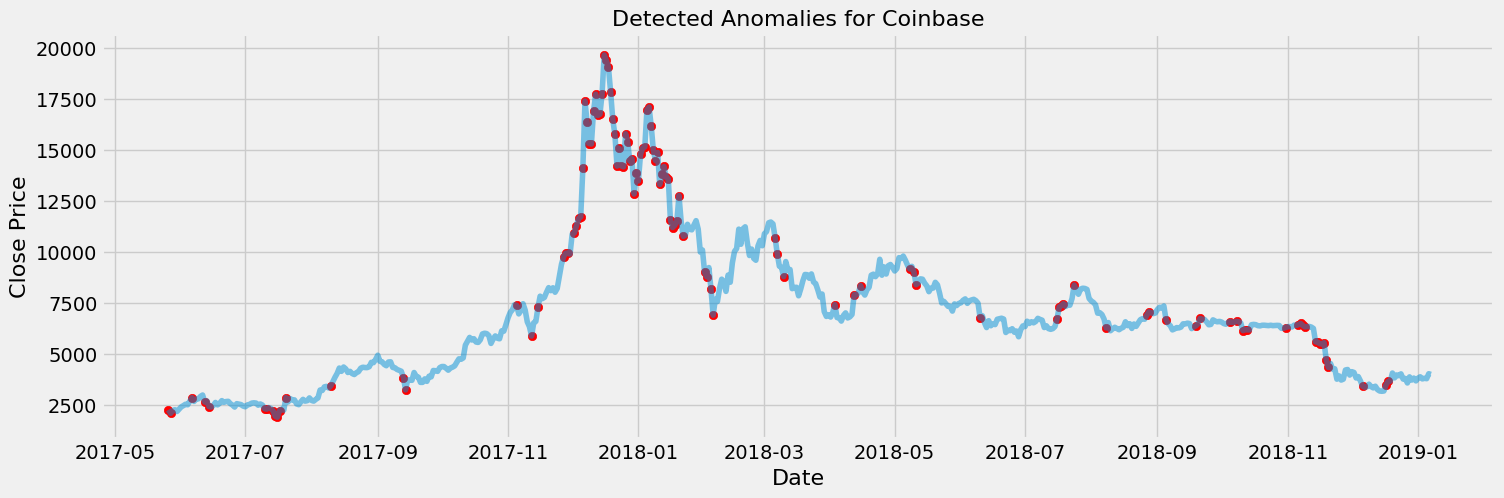

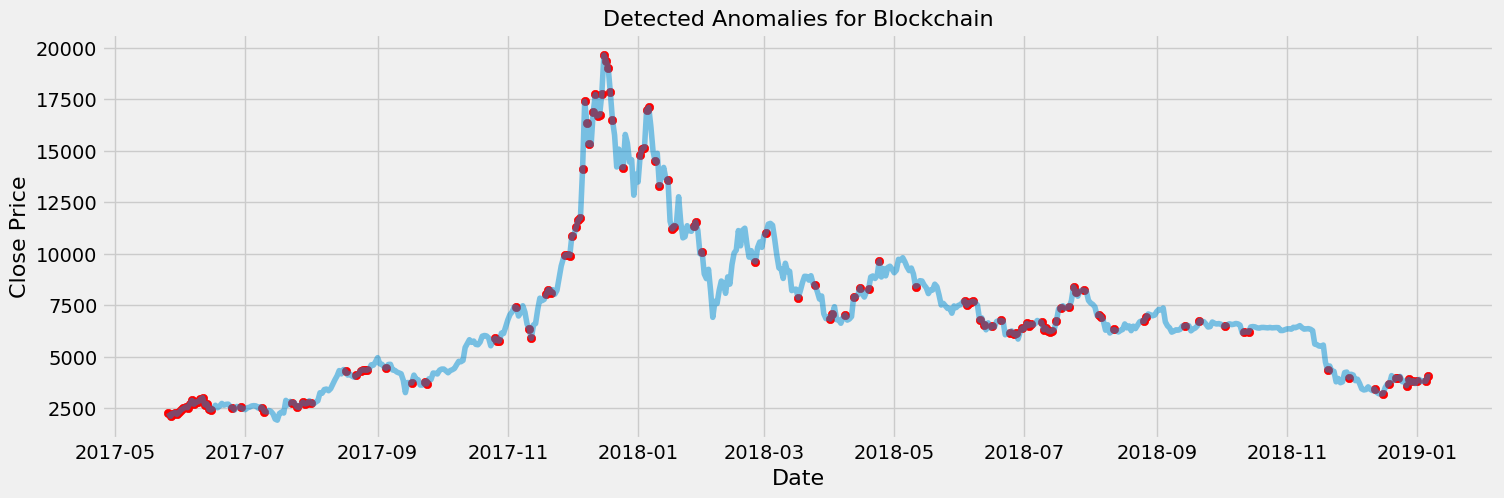

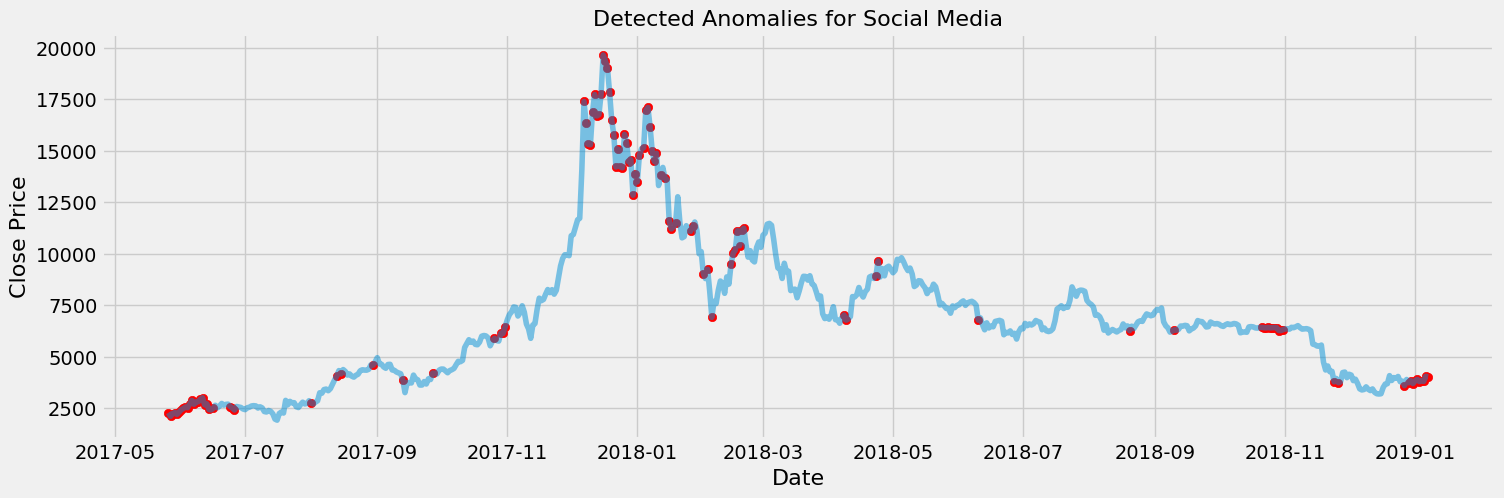

In [20]:
anomaly_chart(coinbase_prices,coinbase,'Close','Coinbase')
anomaly_chart(coinbase_prices,blockchain,'Close','Blockchain')
anomaly_chart(coinbase_prices,social,'Close','Social Media')

## Feature importance 

In [33]:
def scale(df):
    cols = df.columns
    index = df.index
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df)
    X = pd.DataFrame(X)
    X.columns = cols
    X = X.set_index(index)
    return X

def feature_importance(df1,df2,title):
    # make a new column if date was identified as an anomaly
    anomaly_dates_modeling = df1.iloc[:,0]
    df2['anomaly'] = np.where(df2.index.isin(anomaly_dates_modeling), 1, 0)

    # min-max standardization 
    anomalies_classified = scale(df2)
    X1 = anomalies_classified.drop('anomaly', axis=1)
    y1 = anomalies_classified['anomaly']
    # shape of X and y
    display(X1.shape)
    display(y1.shape)

    # feature selection: plot feature importance using built-in function  
    # fit the model
    model = XGBClassifier(random_state=123)
    model.fit(X1, y1)
    # plot feature importance
    plt.rcParams["figure.figsize"] = (14, 7)
    plot_importance(model)
    plt.title('Feature Importance ' + title)
    plt.show()

(592, 46)

(592,)

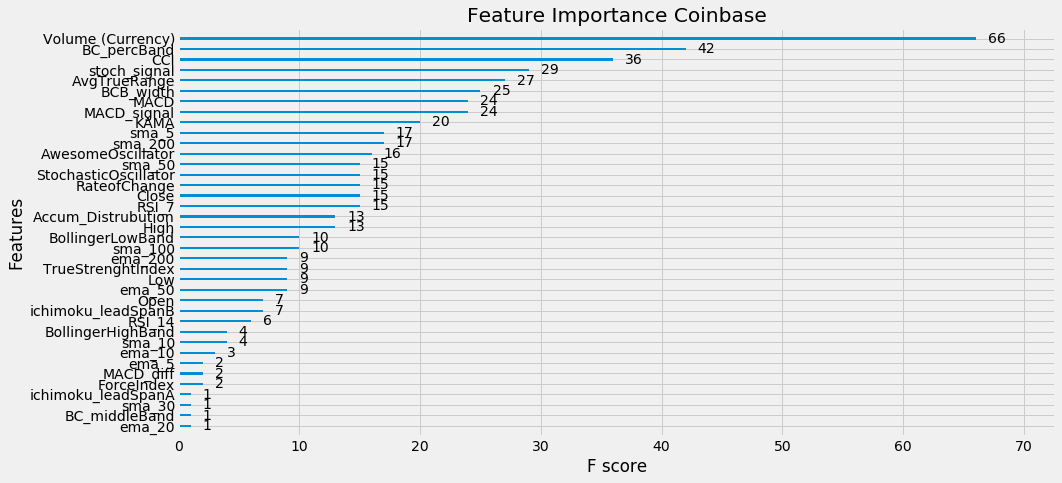

(592, 15)

(592,)

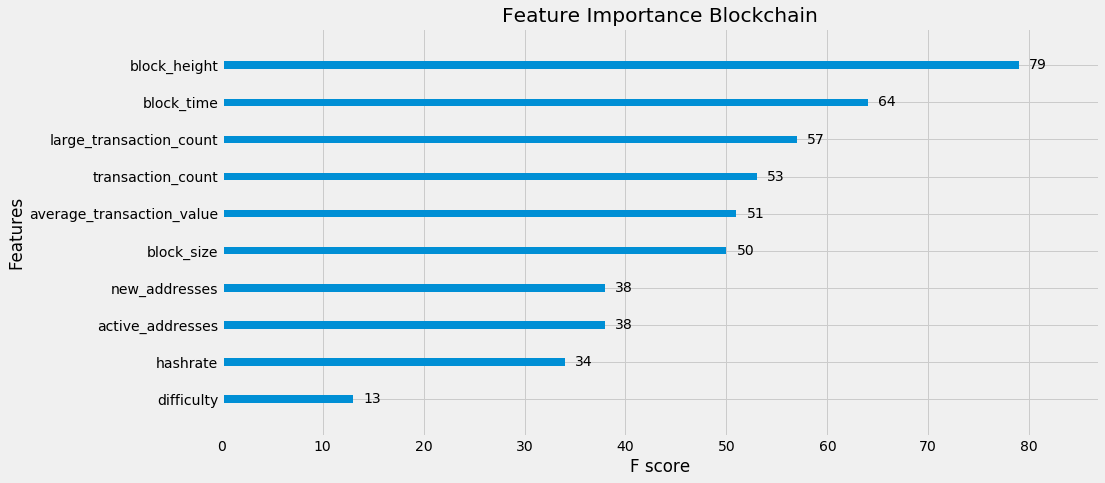

(592, 33)

(592,)

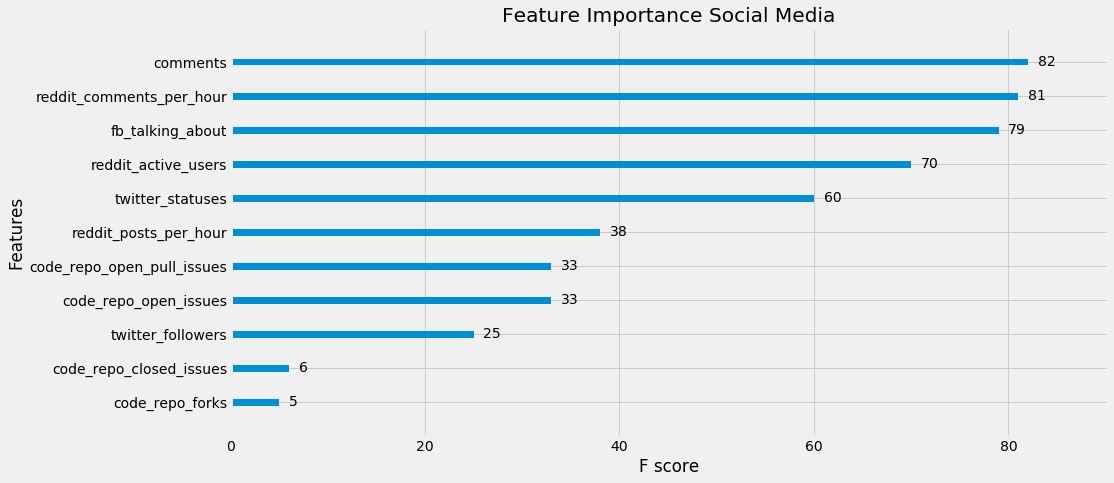

In [34]:
feature_importance(coinbase,coinbase_prices,'Coinbase')
feature_importance(blockchain,blockchain_data,'Blockchain')
feature_importance(social,social_data,'Social Media')

In [ ]:
# prices with blockchain anomalies 
# compare volume pct change to price pct change --> average (where price increases dramatically/not compared to vol inc/dec)

Contrarily, bitcoin prices are influenced by the following factors: The supply of bitcoin and market demand for it. The cost of producing a bitcoin through the mining process. The rewards issued to bitcoin miners for verifying transactions to the blockchain

In [41]:
## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation
#Sample Size
N = 592
#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = coinbase_prices['Volume (Currency)'].var(ddof=1)
var_b = bitstamp_prices['Volume (Currency)'].var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
print('Standard deviation: ',s)

## Calculate the t-statistics
t = (coinbase_prices['Volume (Currency)'].mean() - bitstamp_prices['Volume (Currency)'].mean())/(s*np.sqrt(2/N))

## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)

print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.
## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(coinbase_prices['Volume (Currency)'],bitstamp_prices['Volume (Currency)'])
print("t = " + str(t2))
print("p = " + str(p2))

Standard deviation:  116083435.30046648
t = 4.196245997504569
p = 2.9168897941467264e-05
t = 4.196245997504568
p = 2.916889794150045e-05
